# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.499948,True,6.927137
1,1.736162,True,9.982982
2,1.481919,True,11.448882
3,0.138467,True,6.447027
4,2.542203,True,11.759851
...,...,...,...
995,-2.758366,False,-5.808798
996,-1.284312,True,1.767761
997,-0.245933,False,0.178994
998,2.004202,True,10.099123


<AxesSubplot:xlabel='v0'>

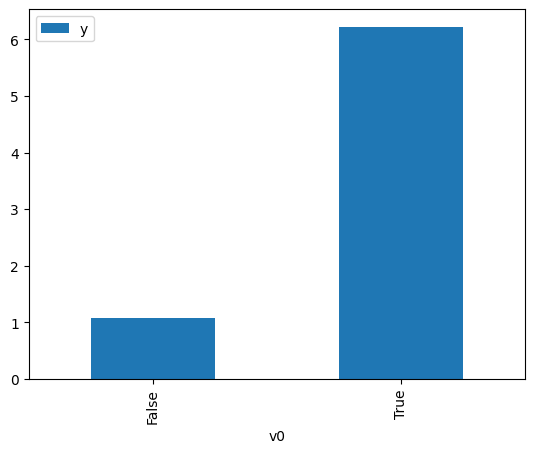

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

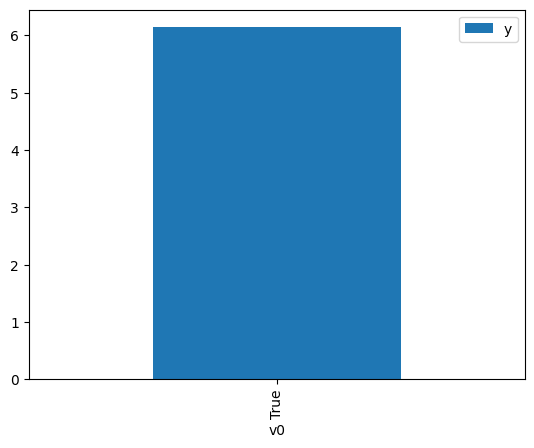

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.152626,False,5.179915,0.018129,55.161479
1,-0.118149,False,-0.546652,0.540961,1.848563
2,0.984111,False,2.248460,0.135492,7.380494
3,-0.835227,False,-1.299399,0.814070,1.228396
4,-0.189947,False,0.473350,0.573372,1.744068
...,...,...,...,...,...
995,1.053491,False,3.971282,0.121294,8.244418
996,1.019562,False,0.773551,0.128070,7.808222
997,1.489139,False,3.341834,0.058547,17.080302
998,2.152626,False,5.179915,0.018129,55.161479


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.088927,True,5.071500,0.885451,1.129368
1,2.009485,True,10.390127,0.976569,1.023993
2,-0.209408,True,5.174009,0.417939,2.392696
3,-0.240248,True,5.301204,0.404274,2.473570
4,0.096704,True,5.370860,0.557009,1.795303
...,...,...,...,...,...
995,0.084669,True,3.992247,0.551567,1.813016
996,1.911185,True,10.252614,0.972079,1.028723
997,1.099164,True,7.688774,0.887337,1.126967
998,-0.703012,True,3.335010,0.225363,4.437282


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                          1.849e+04
Date:                Sat, 20 Aug 2022   Prob (F-statistic):                        0.00
Time:                        00:15:09   Log-Likelihood:                         -1418.3
No. Observations:                1000   AIC:                                      2841.
Df Residuals:                     998   BIC:                                      2850.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1688      0.039     56.279      0.000       2.093       2.244
x2             5.0155      0.053     93.839      0.000       4.911       5.120
==============================================================================
Omnibus:                        0.963   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.618   Jarque-Bera (JB):                0.996
Skew:                           0.075   Prob(JB):                        0.608
Kurtosis:                       2.960   Cond. No.                         2.52
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""